In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM
import utils

rcParams['figure.figsize'] = 14, 8

In [16]:
cam_data = pd.read_pickle('../traffic_data/raw_station_segment_data.pkl')
bus_data = pd.read_pickle('../traffic_data/raw_bus_data.pkl')
bus_data_coords = pd.read_pickle('../traffic_data/raw_data_with_corrigated_coords.pkl')
cam_data_month = pd.read_parquet('../traffic_data/raw_station_segment_data_2021-12-01_2022-01-01.parquet')
cam_data_month['timestamp'] = pd.to_datetime(cam_data_month['timestamp'], unit='s')

In [17]:
bus_data_coords = utils.preprocess_bus_data(bus_data_coords)
bus_data = utils.preprocess_bus_data(bus_data)
bus_data = utils.day_filter(bus_data,10)

In [18]:
scaler = MinMaxScaler()
train_data = utils.create_joined_cam_data(cam_data_month,9)
train_data = train_data.reset_index()
train_data = utils.thresholding(70,90,train_data,True)
train_data = train_data.drop(['timestamp'],axis=1)
train_data = train_data[train_data[['avg_speed', 'total_flow']].notnull().all(1)]
train_data = pd.DataFrame(scaler.fit_transform(train_data))

C:\Users\domon\PycharmProjects\outlier_detection\traffic_outlier_detection\utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[column_name] = frame['value']
C:\Users\domon\PycharmProjects\outlier_detection\traffic_outlier_detection\utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[column_name] = frame['value']


In [19]:
cam_data_joined = utils.create_joined_cam_data(cam_data_month,10)
cam_data_joined = cam_data_joined[cam_data_joined[['avg_speed', 'total_flow']].notnull().all(1)]
cam_data_joined = cam_data_joined.reset_index()
test_data = cam_data_joined.drop(['timestamp'],axis=1)
test_data = pd.DataFrame(scaler.fit_transform(test_data))

C:\Users\domon\PycharmProjects\outlier_detection\traffic_outlier_detection\utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[column_name] = frame['value']
C:\Users\domon\PycharmProjects\outlier_detection\traffic_outlier_detection\utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[column_name] = frame['value']


In [20]:
estimator = OneClassSVM(kernel='rbf',gamma='scale',nu=0.2).fit(train_data)
prediction = estimator.predict(test_data)

In [21]:
print(prediction[:20])
print("Number of outliers detected: {}".format(prediction[prediction < 0].sum()))
print("Number of normal samples detected: {}".format(prediction[prediction > 0].sum()))
print(len(prediction))

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Number of outliers detected: -299
Number of normal samples detected: 1508
1807


In [22]:
normal_data = cam_data_joined[cam_data_joined.index.isin(np.where(prediction > 0)[0])]
outliers = cam_data_joined[cam_data_joined.index.isin(np.where(prediction < 0)[0])]

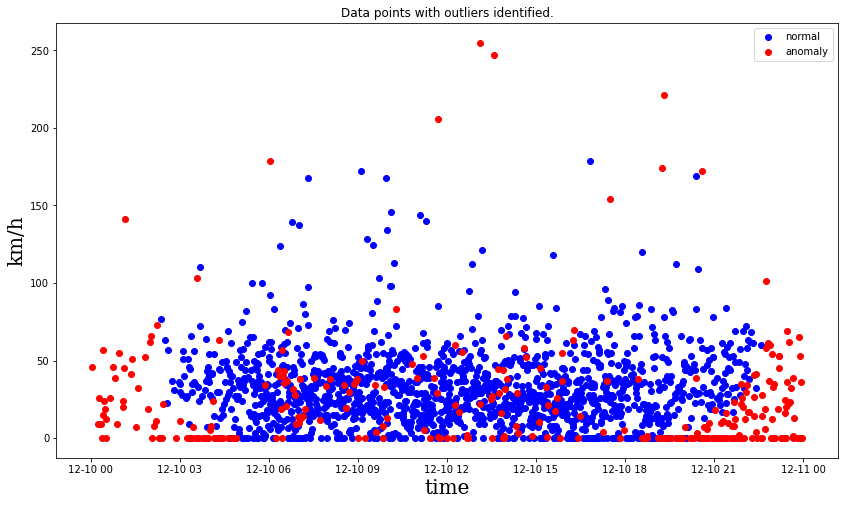

In [23]:
font = {'family':'serif','size':20}
plt.scatter(x=normal_data['timestamp'],y=normal_data['avg_speed'],color='b',label='normal')
plt.scatter(x=outliers['timestamp'],y=outliers['avg_speed'],color='r',label='anomaly')
plt.title("Data points with outliers identified.")
plt.xlabel("time",fontdict=font)
plt.ylabel("km/h",fontdict=font)
plt.legend()
plt.show()

<AxesSubplot:xlabel='timestamp'>

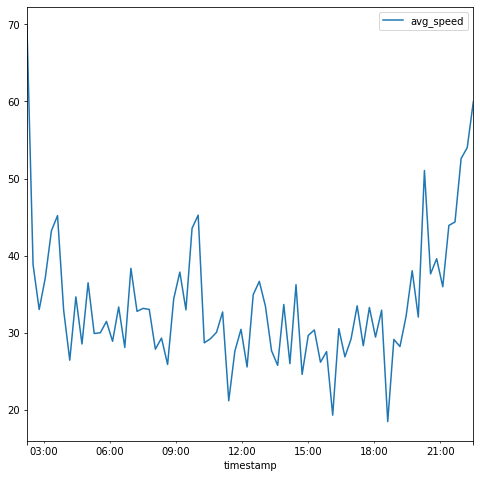

In [24]:
utils.resample(normal_data,'avg_speed',1000).plot.line(x='timestamp',y='avg_speed',figsize=(8,8))

In [25]:
plot_bus = utils.resample(bus_data,'velocity',1000)
plot_camera = utils.resample(normal_data,'avg_speed',1000)
plot_camera_before = utils.resample(cam_data,'avg_speed',1000)
plot_bus = plot_bus[plot_bus['velocity'] != 0]
plot_camera = plot_camera[plot_camera['avg_speed'] != 0]
plot_camera_before = plot_camera_before[plot_camera_before['avg_speed'] != 0]

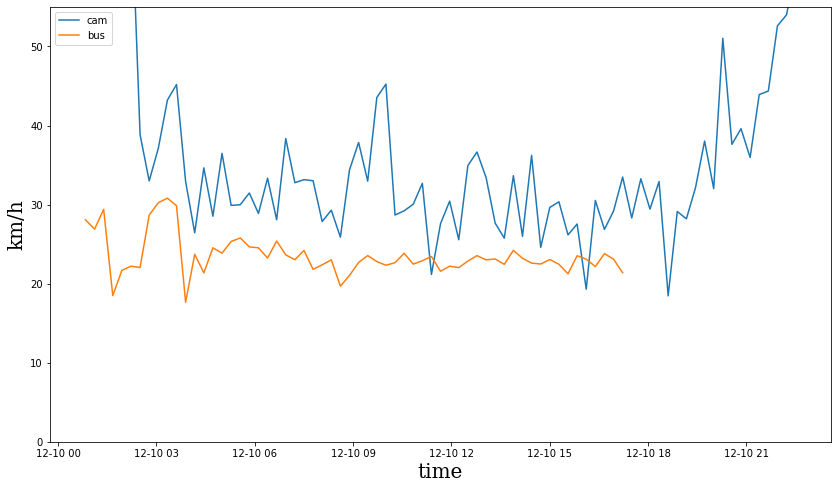

In [26]:
utils.two_line_plot(plot_bus,plot_camera)

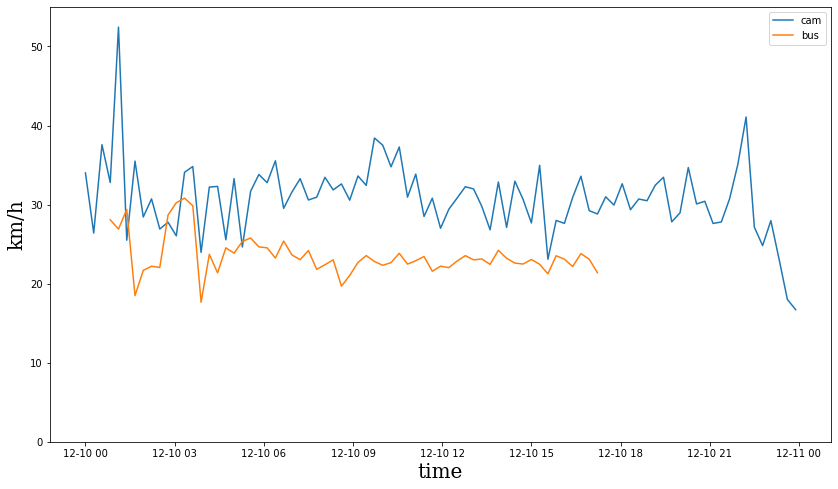

In [27]:
utils.two_line_plot(plot_bus,plot_camera_before)